In [1]:
%load_ext tikzmagic

import ipywidgets as widgets
from ipywidgets import DOMWidget, register, Image
import traitlets as trait
import numpy as np
import pydicom
from matplotlib import pyplot as plt
from IPython.display import display, display_html, display_pretty, Code

from skimage import segmentation
from skimage.filters import gaussian
from skimage.transform import pyramid_expand
from scipy.stats import norm
from scipy import interpolate
from scipy import ndimage

# Drawing widget

In [2]:
@register
class CanvasWidget(DOMWidget):
    _view_name = trait.Unicode('CanvasView').tag(sync=True)
    _view_module = trait.Unicode('drawing').tag(sync=True)
    path = trait.List().tag(sync=True)
    shape = trait.List().tag(sync=True)
    
    def __init__(self, shape):
        super().__init__()
        self.path = []
        self.shape = shape
        
    def get_path(self):
        newPath = np.zeros((len(self.path)//2, 2))
        for i in range(0,len(self.path),2):
            newPath[i//2,0] = self.path[i]
            newPath[i//2,1] = self.path[i+1]
        return newPath

In [3]:
%%javascript
// We make sure the `counter` module is defined
// only once.
require.undef('drawing');

// We define the `counter` module depending on the
// Jupyter widgets framework.
define('drawing', ["@jupyter-widgets/base"], function(widgets) {

    // We create the CounterView frontend class,
    // deriving from DOMWidgetView.
    var CanvasView = widgets.DOMWidgetView.extend({
        
        path: [],
        
        // This method creates the HTML widget.
        render: function() {
            this.model.set('path', []);
            this.model.save_changes();
            
            // The value_changed() method should be
            // called when the model's value changes
            // on the kernel side.
            this.value_changed();
            this.model.on('change:value', this.value_changed, this);
            
            // We create the canvas.
            this.fg = $('<canvas/>').css({
                width: '50px',
                height: '50px',
            }).click(this.clicked_canvas.bind(this))[0];
            
            this.button = $('<button>Fit to background</button>').click(this.do_it.bind(this));
            this.reset_button = $('<button>Reset</button>').click(this.reset.bind(this));
            
            // this.el represents the widget's DOM
            // element. We add the minus button,
            // the span element, and the plus button.
            $(this.el).append(this.fg);
            $(this.el).append(this.button);
            $(this.el).append(this.reset_button);
        },
        
        clicked_canvas: function(event) {
            var canvas = event.target;
            var context = canvas.getContext("2d");
            var pos = this.getMousePos(canvas, event);

            // TODO: include context.clear() followed by a redrawing of the path
            context.strokeStyle = "#f00";
            context.lineTo(pos.x, pos.y);
            context.closePath();
            context.stroke();

            context.beginPath();
            context.moveTo(pos.x, pos.y);

            this.value_changed();
            this.model.save_changes();
        },

        value_changed: function() {
            var newPath = []
            this.path.forEach(function(el) {
                newPath.push(el.x);
                newPath.push(el.y);
            });
            this.model.set('path', newPath);
        },
        
        getMousePos: function(canvas, evt) {
            var rect = canvas.getBoundingClientRect(),
                scaleX = canvas.width / rect.width,
                scaleY = canvas.height / rect.height;
            
            var p = {
              x: (evt.clientX - rect.left) * scaleX,
              y: (evt.clientY - rect.top) * scaleY
            };
            this.path.push({
                x: (evt.clientX - rect.left) * this.model.get('shape')[0] / rect.width,
                y: (evt.clientY - rect.top) * this.model.get('shape')[1] / rect.height
            });
            
            return p
        },
        
        do_it: function(event) {
            var p = $(event.target).parent().parent().parent();
            var bg = $(p).find('.output_png > img');
            var fg = $(p).find('canvas');
            
            var width = bg.width();
            var height = bg.height();
            
            fg.css({
                width: width,
                height: height,
                position: 'absolute',
                left: '5px'
            }).width(width).height(height);
            
            fg.insertAfter(bg);
        },
        
        reset: function(event) {
            const context = this.fg.getContext('2d');
            context.closePath();
            context.clearRect(0, 0, this.fg.width, this.fg.height);
            context.beginPath();
            
            this.path = []
            this.model.set('path', this.path);
            this.model.save_changes();
        }
    });

    return {
        CanvasView : CanvasView
    };
});

<IPython.core.display.Javascript object>

# Loading data

In [4]:
ds = pydicom.read_file('../Data/Train_Sets/CT/1/DICOM_anon/i0038,0000b.dcm')
ConstPixelDims = (int(ds.Rows), int(ds.Columns))
ConstPixelSpacing = (float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1]), float(ds.SliceThickness))

ct_scan = np.zeros(ConstPixelDims, dtype=ds.pixel_array.dtype)
ct_scan[:,:] = ds.pixel_array

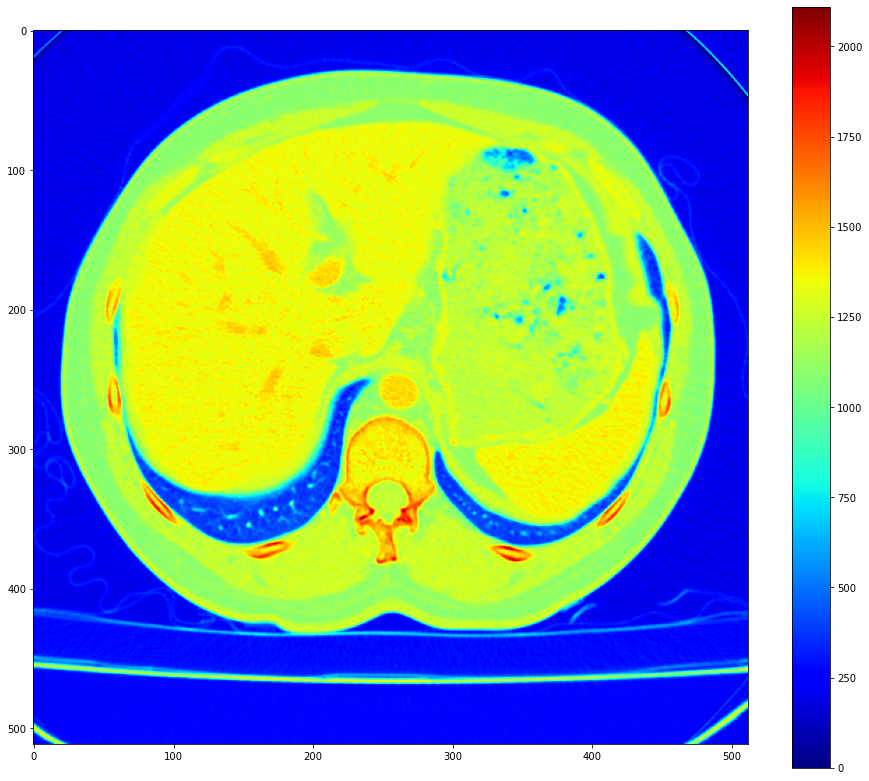

In [5]:
plt.figure(figsize=(16,14))
ax = plt.gca()
plt.imshow(ct_scan, cmap='jet')
plt.colorbar()
plt.show()

# drawing a contour

In [6]:
out = widgets.Output()
with out:
    plt.figure(figsize=(17,17))
    ax = plt.gca()
    plt.imshow(ct_scan, cmap='gray')
    ax.axis('off')
    plt.show()

painting = CanvasWidget(ct_scan.shape)

layout = widgets.VBox([
    out,
    widgets.Box([painting])
])
display(layout)

In [7]:
initial_contour = painting.get_path()
initial_contour

array([[316.26097748, 305.29864905],
       [327.17782183, 322.76560001],
       [343.00724614, 342.96176206],
       [363.7492504 , 350.60355311],
       [389.94967684, 350.60355311],
       [409.59999667, 332.59075993],
       [434.16289646, 314.03212453],
       [436.34626533, 289.46922475],
       [447.80895189, 261.08542944],
       [449.99232076, 235.43084522],
       [453.81321628, 199.40525886],
       [439.07547641, 204.31783882],
       [428.15863206, 216.87220982],
       [421.60852545, 243.07263626],
       [406.32494336, 265.45216718],
       [379.03283249, 282.91911814],
       [357.19914379, 287.83169809],
       [328.26950626, 290.01506696],
       [318.44434635, 297.11101579]])

# Linear interpolation

In [8]:
def interpolate_segments(contour, amount=2):
    c = np.array(contour)
    
    interpolated_contour = np.array([[np.linspace(c[i,0], c[i+1,0], amount), np.linspace(c[i,1], c[i+1,1], amount)] for i in range(0,c.shape[0]-1,2)])
    interpolated_contour = np.transpose(interpolated_contour, [0,2,1]).reshape((-1,2))
    return interpolated_contour

initial_contour = interpolate_segments(initial_contour, 3)
initial_contour

array([[316.26097748, 305.29864905],
       [321.71939965, 314.03212453],
       [327.17782183, 322.76560001],
       [343.00724614, 342.96176206],
       [353.37824827, 346.78265758],
       [363.7492504 , 350.60355311],
       [389.94967684, 350.60355311],
       [399.77483675, 341.59715652],
       [409.59999667, 332.59075993],
       [434.16289646, 314.03212453],
       [435.25458089, 301.75067464],
       [436.34626533, 289.46922475],
       [447.80895189, 261.08542944],
       [448.90063633, 248.25813733],
       [449.99232076, 235.43084522],
       [453.81321628, 199.40525886],
       [446.44434635, 201.86154884],
       [439.07547641, 204.31783882],
       [428.15863206, 216.87220982],
       [424.88357876, 229.97242304],
       [421.60852545, 243.07263626],
       [406.32494336, 265.45216718],
       [392.67888793, 274.18564266],
       [379.03283249, 282.91911814],
       [357.19914379, 287.83169809],
       [342.73432503, 288.92338253],
       [328.26950626, 290.01506696]])

# Active Contour (snake)
Kass, M.; Witkin, A.; Terzopoulos, D. “Snakes: Active contour models”. International Journal of Computer Vision 1 (4): 321 (1988). [DOI:10.1007/BF00133570](https://doi.org/10.1007/BF00133570)

In [9]:
alpha = 0.01
beta = 0.01
w_line = -500
w_edge = 100

fitted_contour = segmentation.active_contour(ct_scan, initial_contour, alpha=alpha, beta=beta, w_line=w_line, w_edge=w_edge, max_iterations=5)
fitted_contour

array([[313.51727873, 308.62612676],
       [318.75724368, 318.2247612 ],
       [327.98468109, 325.84120347],
       [346.09099668, 340.18026796],
       [356.35395208, 344.03615958],
       [368.65747165, 348.15720398],
       [389.63489373, 347.60570783],
       [402.77466574, 339.49310585],
       [412.60219243, 331.5923244 ],
       [435.16387739, 315.74728825],
       [437.65830079, 302.78834793],
       [439.98341045, 290.47300458],
       [445.58182478, 266.08540262],
       [447.94321528, 251.25668341],
       [450.84672272, 236.22489111],
       [454.77597205, 204.40525886],
       [449.44424907, 206.8613017 ],
       [442.07547641, 208.73052748],
       [431.15863206, 221.86852671],
       [427.88357876, 234.97238257],
       [424.60852691, 248.07263376],
       [411.32490833, 269.13233377],
       [397.67647859, 275.54386993],
       [376.38508707, 283.98737706],
       [354.2491991 , 289.02693605],
       [339.73432504, 291.92354809],
       [325.26953093, 294.79739445]])

In [11]:
fitted_contour = segmentation.active_contour(ct_scan, fitted_contour, alpha=alpha, beta=beta, w_line=w_line, w_edge=w_edge, max_iterations=500)

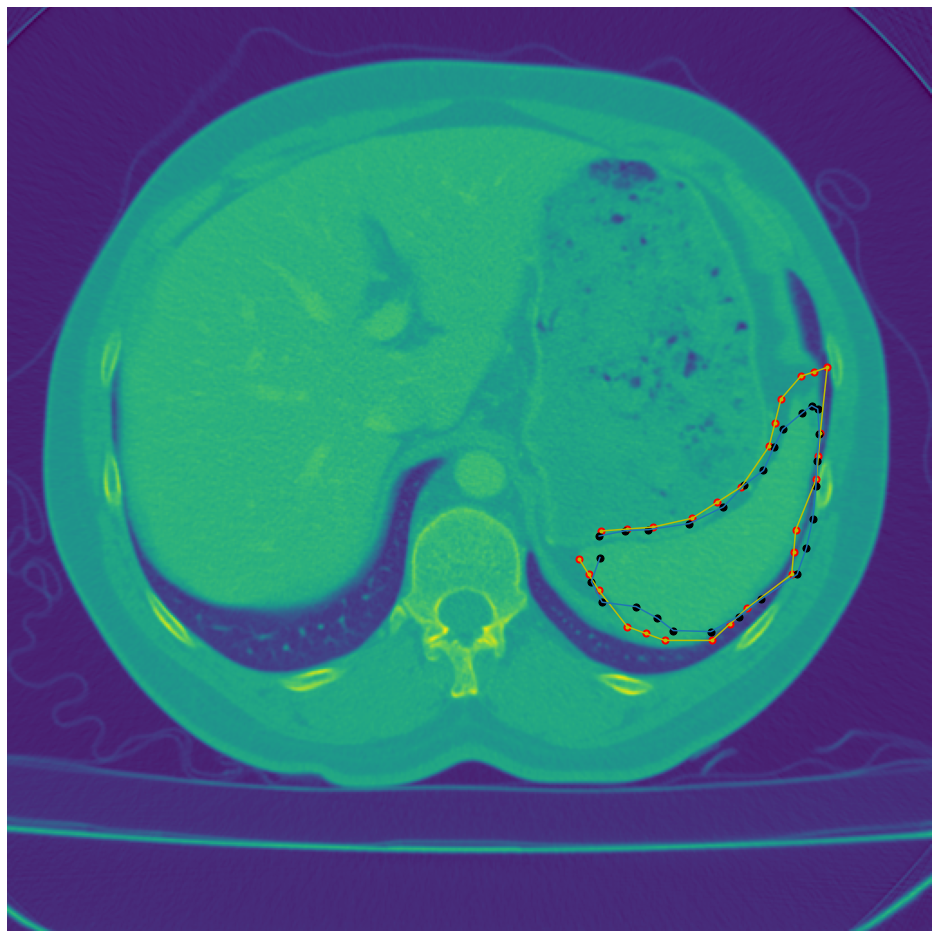

In [12]:
plt.figure(figsize=(17,17))
ax = plt.gca()
plt.imshow(ct_scan)
plt.scatter(initial_contour[:,0], initial_contour[:,1], s=50, c='red')
plt.plot(initial_contour[:,0], initial_contour[:,1], '.-y')
plt.scatter(fitted_contour[:,0], fitted_contour[:,1], s=50, c='k')
plt.plot(fitted_contour[:,0], fitted_contour[:,1])
ax.axis('off')
plt.show()

# Contour values
TODO: Interpolate betwen pixels.

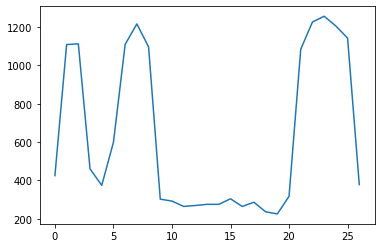

In [13]:
values = np.array([ct_scan[y,x] for x,y in fitted_contour.astype(np.int64) ])
values_initial = np.array([ct_scan[y,x] for x,y in initial_contour.astype(np.int64) ])

values_interpolated = ndimage.map_coordinates(ct_scan, fitted_contour.T, order=1)

plt.plot(values_interpolated)
plt.show()

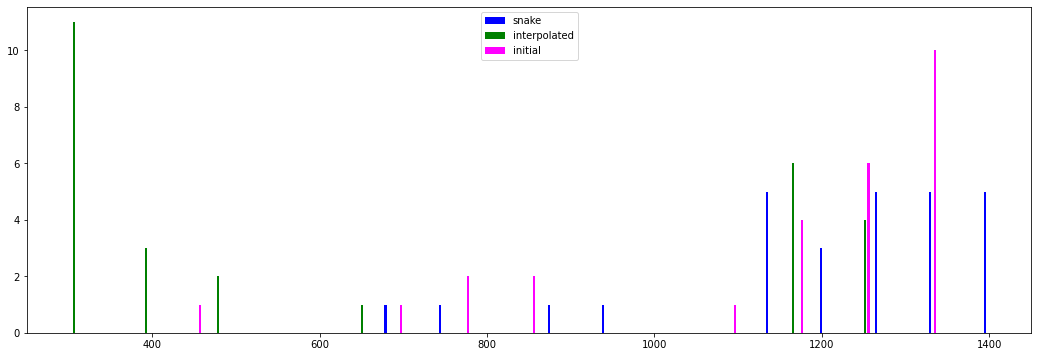

In [14]:
hist_values, edges_values = np.histogram(values, 12)
hist_interpolated, edges_inerpolated = np.histogram(values_interpolated, 12)
hist_initial, edget_initial = np.histogram(values_initial, 12)

plt.figure(figsize=(18,6))
plt.bar(edges_values[1:]-2.5, hist_values, 2.5, color='blue', label='snake')
plt.bar(edges_inerpolated[1:]-5, hist_interpolated, 2.5, color='green', label='interpolated')
plt.bar(edget_initial[1:]+2.5, hist_initial, 2.5, color='magenta', label='initial')
plt.legend()
plt.show()

# Level-Crossing Probability

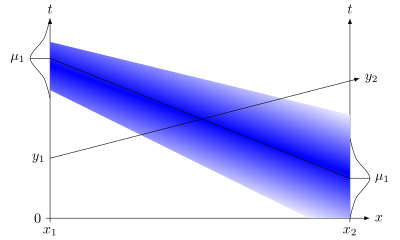

In [15]:
%%tikz -f svg

\newbox\mybox
\newcommand{\tikzBox}[2][\mybox]{%
  \sbox#1{\pgfinterruptpicture#2\endpgfinterruptpicture}}

\draw[-latex] (0,-0.1) node[left,anchor=north] {$x_1$} -- (0,5) node[above] {$t$};
\draw[-latex] (-0.1,0) node[below,anchor=east] {$0$} -- (8,0) node[right] {$x$};
\draw[-latex] (7.5,-0.1) node[below] {$x_2$} -- (7.5,5) node[above] {$t$};

\draw plot [smooth] coordinates {(0,5) (-0.15,4.5) (-0.5,4) (-0.15,3.5) (0,3)};
\draw (-0.5,4) node[left] {$\mu_1$} -- (0, 4);

\draw plot [smooth] coordinates {(7.5,2) (7.65,1.5) (8,1) (7.65,0.5) (7.5,0)};
\draw (8,1) node[right] {$\mu_1$} -- (7.5, 1);

\begin{scope}
    \clip (0,0) rectangle (7.5,5);
    \tikzBox{%
    \tikz\shadedraw[top color=white, bottom color=white, middle color=blue,draw=none] (0,-0.5) -- (0,0.5) -- (9,1.5) -- (9,-1.5) -- cycle;%
    }
    \path[rotate=-20,transform shape] (-1.9,2.1) node[inner sep=0pt,outer sep=0pt,anchor=south west]{\usebox\mybox};
\end{scope}
                                 
\draw[-latex] (0,1.5) node[left] {$y_1$} -- (7.75,3.5) node[right] {$y_2$};

\draw (0,4) -- (7.5,1);

\begin{align}
    prob_{[x_i,x_j]}(Y_{1,2} crossed) =& prob(Y_j \leq y_1) prob(Y_k \geq y_2) \\
    &+ prob(Y_j \geq y1) prob(Y_k \leq y2) \\
    =& F_j(y_1) \left(1 - F_k(y_2) \right) \\
    &+ \left( 1 - F_j(y_1) \right) F_K(y_2)
\end{align}

The value of the function is related to the numerical condition of isocontour extraction. In other words, how sensitive is the extraction of the isocontour to small pertubations $d t$ based on the normal distribution.

In [28]:
def lcp(y1, y2, mean, variance):
    F_j = norm.cdf(y1, mean, variance)
    F_k = norm.cdf(y2, mean, variance)
    return F_j * (1 - F_k) + (1 - F_j) * F_k

# Load the STD of the radon transform

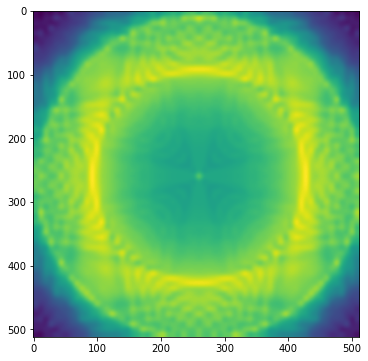

In [29]:
std = np.load('../Data/inverse_Radon_Transform/std_64x64_expdecay246.4x10.npy')
std = pyramid_expand(std, 8)

plt.figure(figsize=(6,6))
plt.imshow(std)
plt.show()

In [32]:
@widgets.interact(segment=(0,values.shape[0]-1), line=widgets.fixed(fitted_contour), mean=widgets.fixed(ct_scan), variance=widgets.fixed(std))
def inspect(segment, line, mean, variance):
    values = ndimage.map_coordinates(mean, line.T, order=1)
    #values = np.array([mean[x,y] for x,y in line.astype(np.int64) ])
    
    s1 = segment
    s2 = (segment+1) % values.shape[0]
    
    y1 = values[s1]
    y2 = values[s2]
    
    l = lcp(y1, y2, mean, variance)
    
    p1 = line[s1]
    p2 = line[s2]
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(1,2,1)
    plt.imshow(l)
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(mean, cmap='gray')
    plt.scatter([p1[0], p2[0]], [p1[1], p2[1]], s=25, c='red')
    plt.plot(line[:,0], line[:,1], '.-y')
    
    plt.show()

interactive(children=(IntSlider(value=13, description='segment', max=26), Output()), _dom_classes=('widget-int…

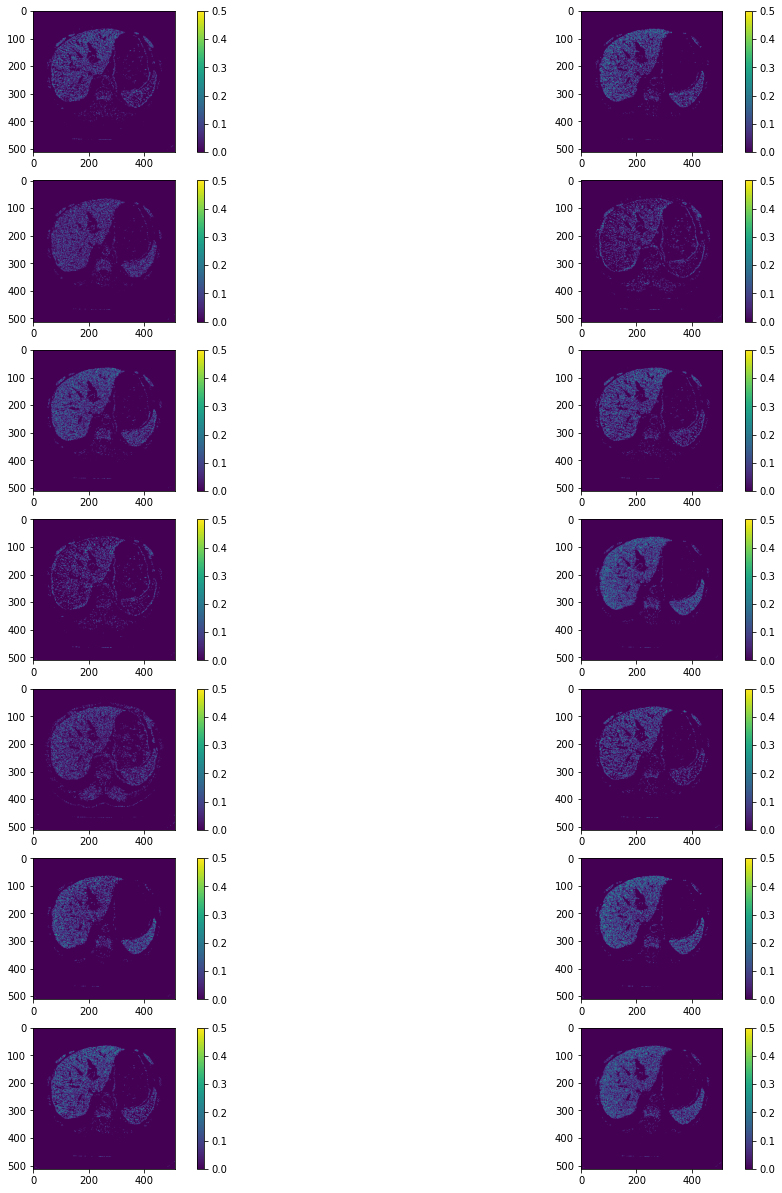

In [31]:
plt.figure(figsize=(18,40))
n = values.shape[0]

lcps = []

for i in range(0, n, 2):
    plt.subplot(n//2, 2, i//2+1)
    
    y1 = values_interpolated[i]
    y2 = values_interpolated[ (i+1) % n ]
    l = lcp(y1, y2, ct_scan, std)
    lcps.append(l)
    
    plt.imshow(l)
    plt.colorbar()
    
if n % 2 == 0:
    # close the loop on even segment count
    plt.subplot(n//2, 2, (n+1)//2+1)
    y1 = values_interpolated[-1]
    y2 = values_interpolated[0]
    l = lcp(y1, y2, ct_scan, std)
    lcps.append(l)

    plt.imshow(l)
    plt.colorbar()
    
plt.show()

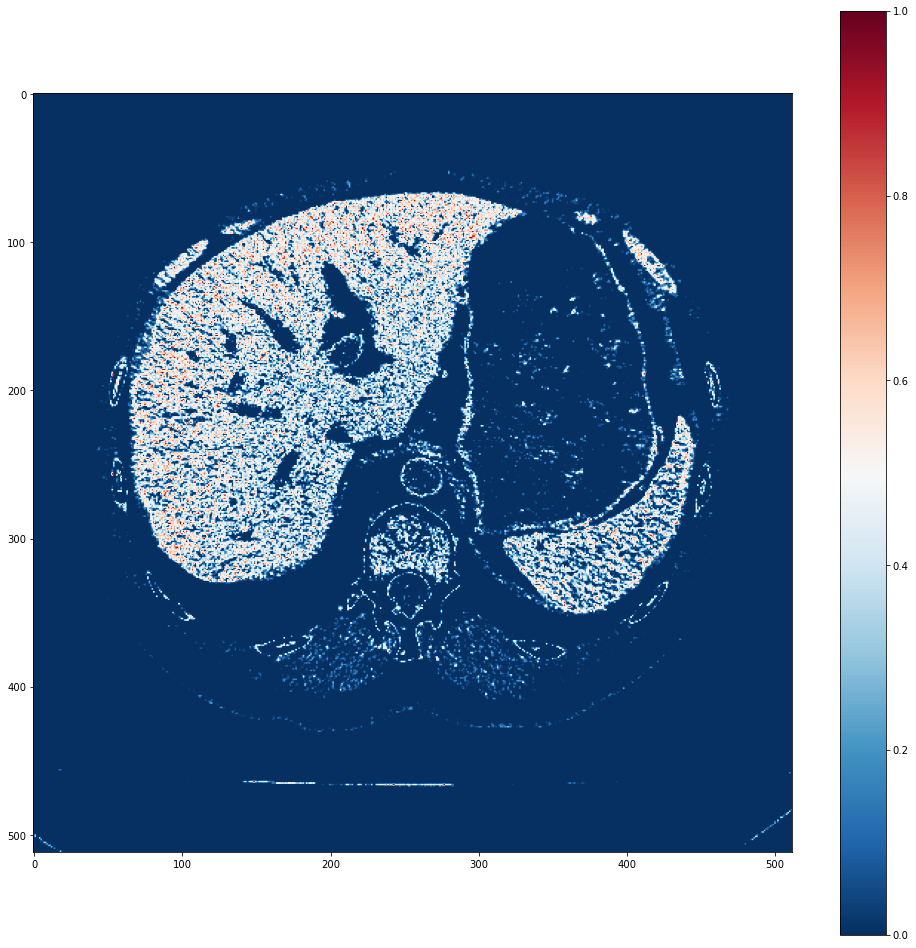

In [38]:
or_conjunction = np.sum(lcps, axis=0)
or_conjunction /= or_conjunction.max()
and_conjunction = np.prod(lcps, axis=0)

plt.figure(figsize=(17,17))
plt.imshow(or_conjunction, cmap='RdBu_r')
plt.colorbar()

plt.show()

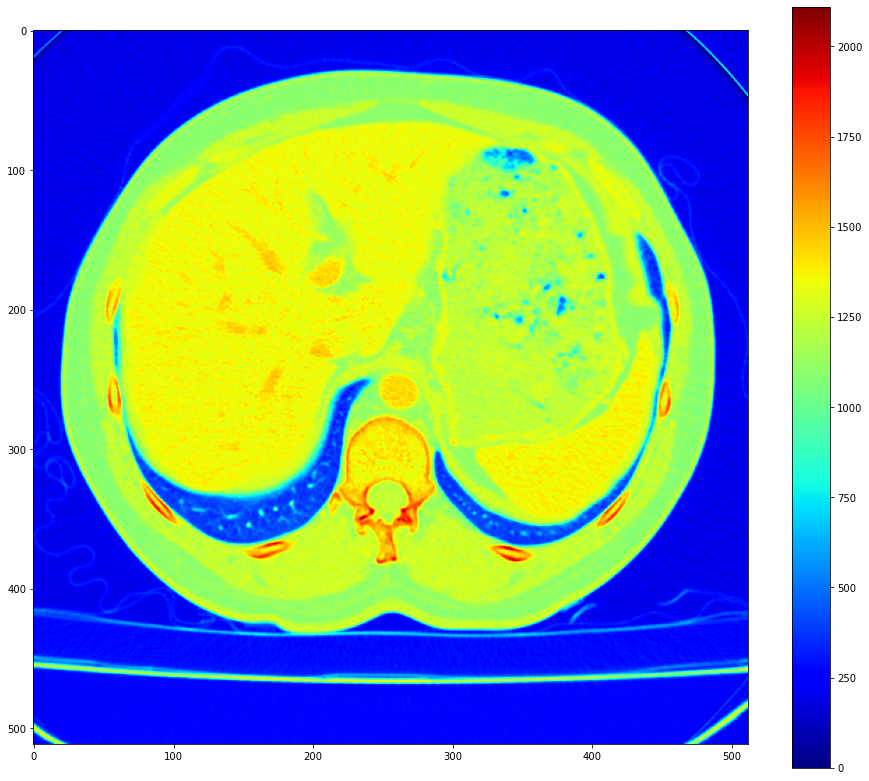

In [101]:
plt.figure(figsize=(16,14))
ax = plt.gca()
plt.imshow(ct_scan, cmap='jet')
plt.colorbar()
plt.show()